In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [130]:
import numpy as np
import ot
import os
import matplotlib.pyplot as plt
from joint_OT_mapping_linear_classreg import joint_OT_mapping_linear
import torch
from einops import rearrange
from MNISTDigitDataset import MNISTDigitDataset
from torchvision import transforms
from utils import plot_pca_for_arrays, plot_images_from_datasets, visualize_barycenter_diracs, plot_flattened_images, test_svm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu')
print('Using device: {}'.format(device))

Using device: cpu


In [3]:
%load_ext autoreload
%autoreload 2

# Data setup

In [4]:
target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])

ds_4 = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform,
                         digit=4)
ds_2 = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform,
                         digit=2)
ds_4jr = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform,
                         digit=4)
ds_2jr = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform,
                         digit=2)

In [5]:
n_samples = 50
indices = np.arange(n_samples, dtype=int)

# Take the images
X_2 = np.array(ds_2.__getitem__(indices)[0])
X_4 = np.array(ds_4.__getitem__(indices)[0])
X_2jr = np.array(ds_2jr.__getitem__(indices)[0])
X_4jr = np.array(ds_4jr.__getitem__(indices)[0])

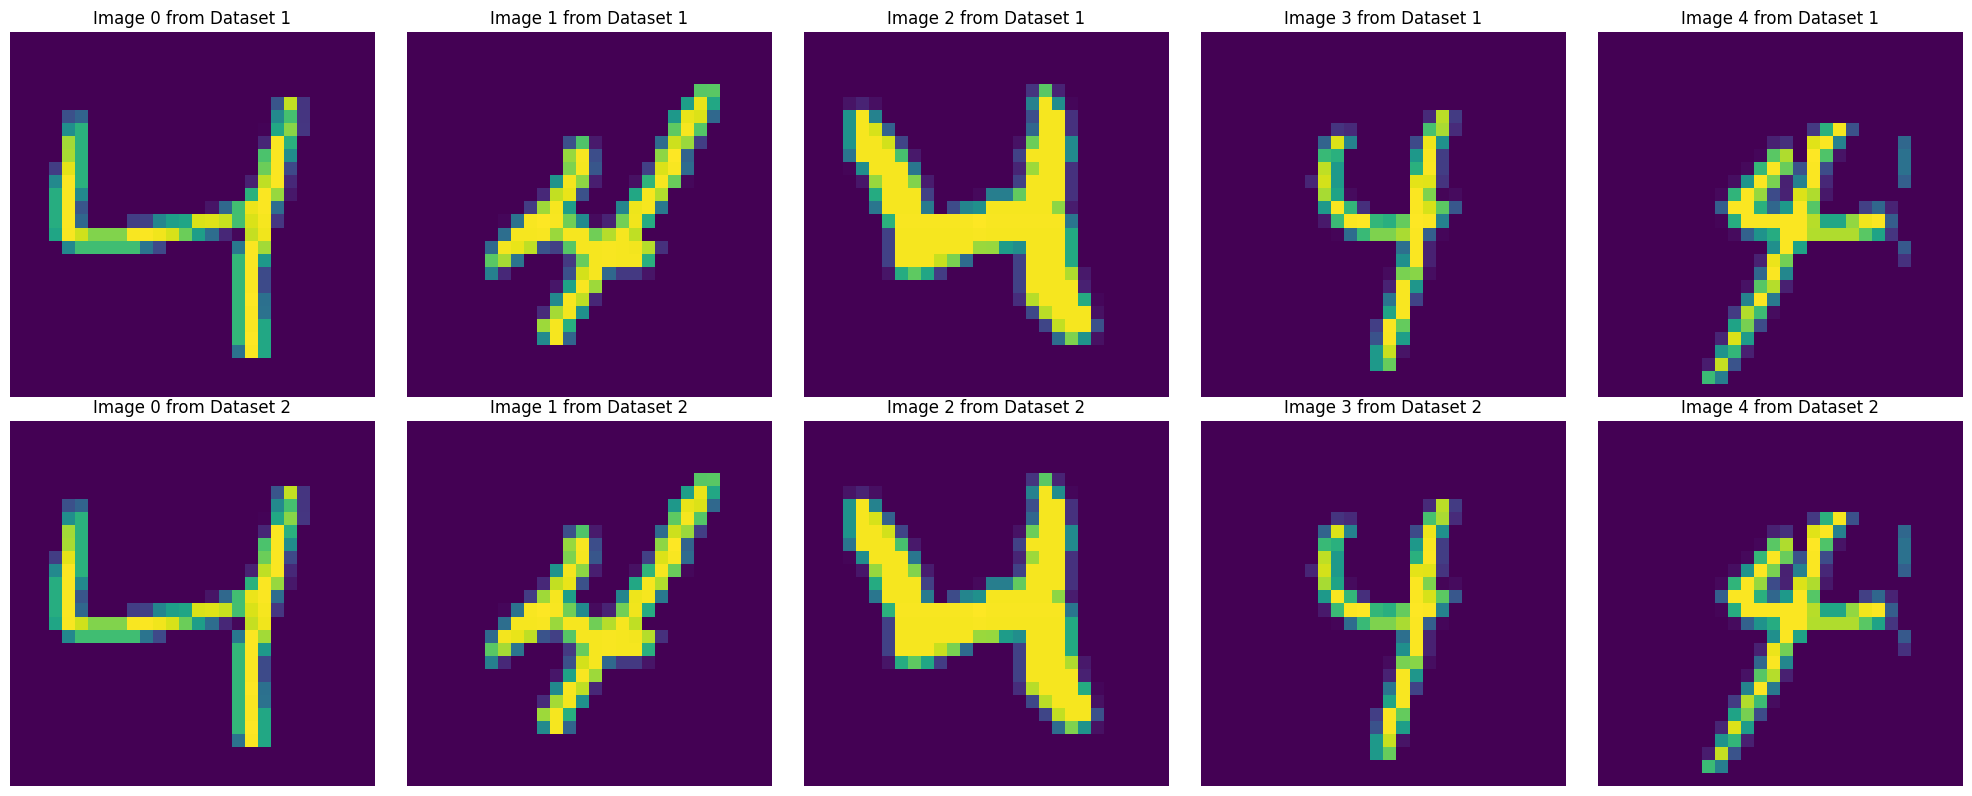

<Figure size 640x480 with 0 Axes>

In [6]:
plot_images_from_datasets(datasets=[ds_4, ds_4jr], num_images=5)

Make the domain difference. It is represented as a linear transformation L and bias b

In [7]:
noise_scale = 0.2
L_0 = np.eye(784, dtype=int) + (np.diag(np.random.randn(784, ) * noise_scale))
b_0 = np.array([0.1] * 784, dtype=float)

X_2_l = X_2jr @ L_0 + b_0
X_4_l = X_4jr @ L_0 + b_0

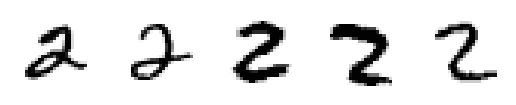

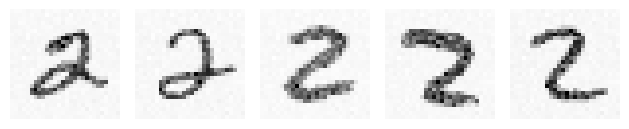

In [8]:
plot_flattened_images([X_2, X_2_l])

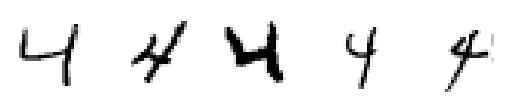

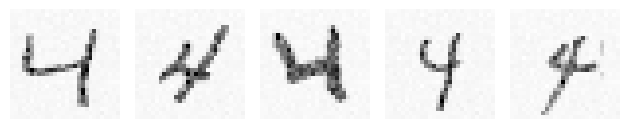

In [9]:
plot_flattened_images([X_4, X_4_l])

In [10]:
del X_2jr
del X_4jr

We now consider measures. Each dataset will be considered a measure:

$\mu = \sum a_i \delta_{xi}$

meaning that every image in the dataset is a dirac delta at point $x$, with probability mass of $a_i$. $x$ is the location of the dirac, and it has the coordinates of the flattened image. 

In [11]:
ds_2.__len__(), ds_4.__len__(), ds_2jr.__len__(), ds_4jr.__len__()

(5958, 5842, 5958, 5842)

Lets chose a training set of 1000 images from each dataset

In [12]:
X_2.shape, X_4.shape, X_2_l.shape, X_4_l.shape

((50, 784), (50, 784), (50, 784), (50, 784))

Set the probability masses to uniform 1/n

In [13]:
a_i = 1.0 / n_samples
w_i = torch.ones(size=(n_samples,)) * a_i

Visualize the principal components of the datasets

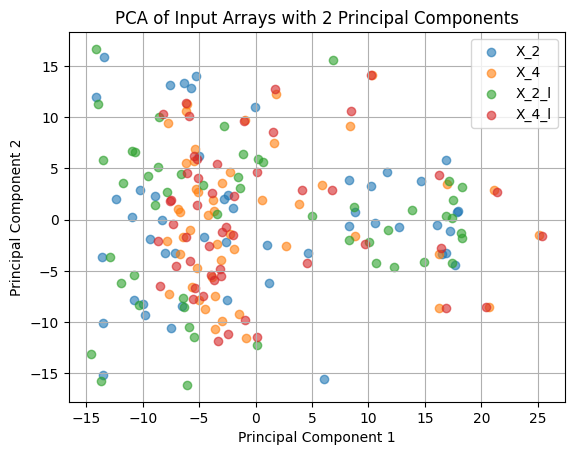

In [14]:
plot_pca_for_arrays(arrays=[X_2, X_4, X_2_l, X_4_l],
                    n_components=2,
                    labels=['X_2', 'X_4', 'X_2_l', 'X_4_l'])
plt.show()

# Compute the free-support Sinkhorn barycenter of the measures

In [15]:
X_2 = torch.tensor(X_2, device=device, dtype=torch.float32)
X_4 = torch.tensor(X_4, device=device, dtype=torch.float32)
X_2_l = torch.tensor(X_2_l, device=device, dtype=torch.float32)
X_4_l = torch.tensor(X_4_l, device=device, dtype=torch.float32)

In [25]:
recompute = True

if not recompute and os.path.exists('barycenter.npy'):
    barycenter = np.load('barycenter.npy')
else:
    barycenter = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations=[X_2, X_4, X_2_l, X_4_l],
        measures_weights=[w_i, w_i, w_i, w_i],
        X_init=torch.randn((2*n_samples, X_2.shape[1]), dtype=torch.float32, device=device),
        reg=25.0,
        b=torch.ones((n_samples * 2,), dtype=torch.float32, device=device) / (n_samples*2),
        numItermax=2000000,
        numInnerItermax=1000,
        verbose=True,
        stopThr=1e-7
    )
    # Save barycenter if kernel needs to be restarted
    np.save('barycenter.npy', barycenter)

/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration %d, displacement_square_norm=%f
 0 tensor(104582.0781)
iteration %d, displacement_square_norm=%f
 1 tensor(3821.2698)
iteration %d, displacement_square_norm=%f
 2 tensor(2198.4941)
iteration %d, displacement_square_norm=%f
 3 tensor(1303.5896)
iteration %d, displacement_square_norm=%f
 4 tensor(444.1250)
iteration %d, displacement_square_norm=%f
 5 tensor(184.5690)
iteration %d, displacement_square_norm=%f
 6 tensor(80.0471)
iteration %d, displacement_square_norm=%f
 7 tensor(51.0287)
iteration %d, displacement_square_norm=%f
 8 tensor(27.3038)
iteration %d, displacement_square_norm=%f
 9 tensor(7.9998)
iteration %d, displacement_square_norm=%f
 10 tensor(5.7826)
iteration %d, displacement_square_norm=%f
 11 tensor(11.4251)
iteration %d, displacement_square_norm=%f
 12 tensor(19.6669)
iteration %d, displacement_square_norm=%f
 13 tensor(4.4136)
iteration %d, displacement_square_norm=%f
 14 tensor(1.3659)
iteration %d, displacement_square_norm=%f
 15 tensor(0.3636)
iteration %

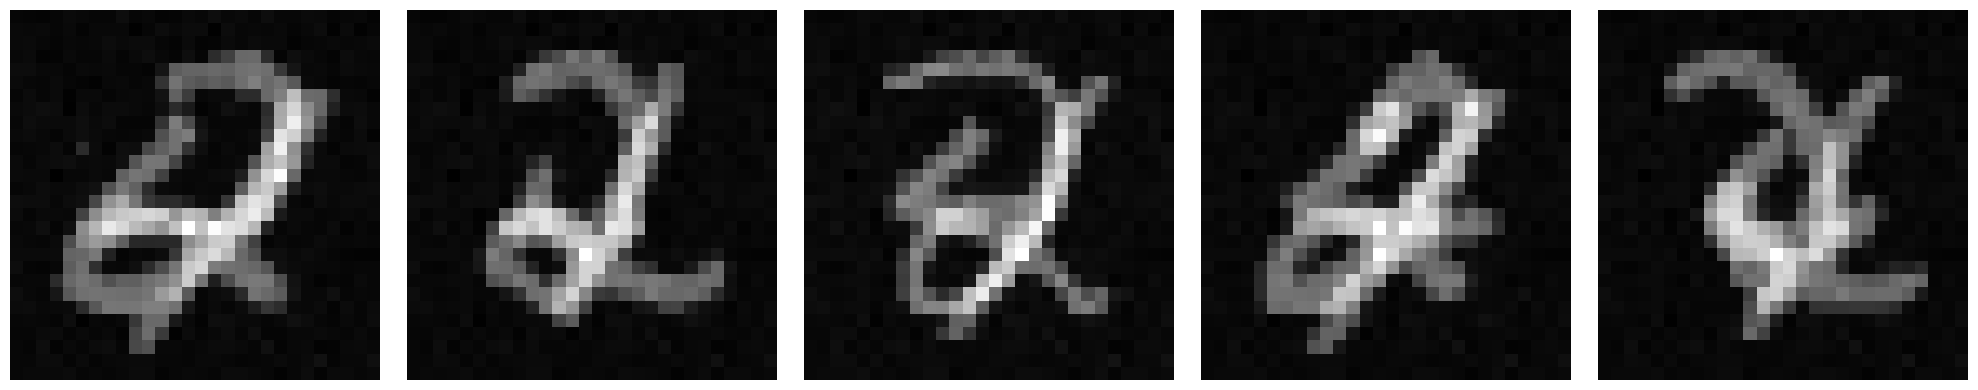

In [26]:
visualize_barycenter_diracs(barycenter=barycenter, num_images=5)

In [27]:
barycenter.shape

torch.Size([100, 784])

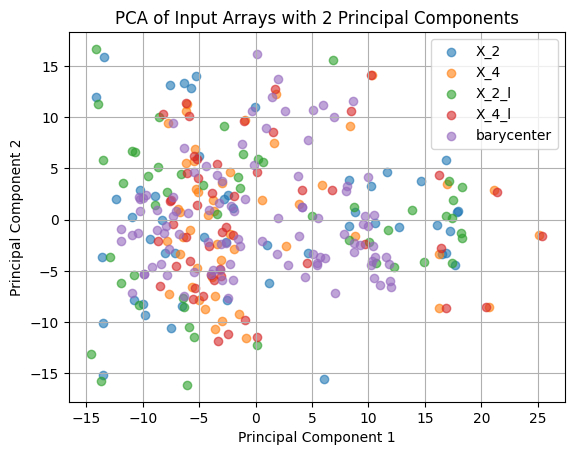

In [28]:
plot_pca_for_arrays(arrays=[X_2, X_4, X_2_l, X_4_l, barycenter],
                    n_components=2,
                    labels=['X_2', 'X_4', 'X_2_l', 'X_4_l', "barycenter"])
plt.show()

# Compute the Kantorovich and Monge solutions jointly
From the different measures to the barycenter.

- Kantorovich: One measure has 1000 dirac deltas at positions $x_i \in \mathbb{R}^{784}$, therefore the coupling matrices have shape $784 \times 784$.
- Monge: The map T is to be found as a linear transformation (represented by matrix $L \in \mathbb{R}^{784 \times 784}$) with a bias term (which makes it a matrix $\mathbb{R}^{785 \times 784}$).

In [33]:
xs1 = rearrange(torch.stack(
    [X_2, X_4],
    dim=0),
    'a b c -> (a b) c')
xs2 = rearrange(torch.stack(
    [X_2_l, X_4_l],
    dim=0),
    'a b c -> (a b) c')

# Label to best separate the samples
ys1 = rearrange(torch.stack([torch.ones((n_samples,), device=device) * 2, torch.ones((n_samples,), device=device) * 4]), 'a b -> (a b)')
ys2 = rearrange(torch.stack([torch.ones((n_samples,), device=device) * 2, torch.ones((n_samples,), device=device) * 4]), 'a b -> (a b)')

xt = barycenter.clone().detach()
yt = rearrange(torch.stack([torch.ones((n_samples,),device=device) * 2, torch.ones((n_samples,), device=device) * 4]), 'a b -> (a b)')

In [120]:
G, L, loss = joint_OT_mapping_linear(xs=xs1,
                             xt=xt,
                             ys=ys1,
                             yt=yt,
                             mu=15.0,
                             eta=10.0,
                             bias=True,
                             verbose=True,
                             numItermax=100000,
                             numInnerItermax=100000,
                             stopInnerThr=1e-10,
                             stopThr=1e-10,
                             log=True,
                             class_reg=True)

It.  |Loss        |Delta loss
--------------------------------
    0|5.208555e+05|0.000000e+00
    1|5.208347e+05|-3.995830e-05
    2|5.208200e+05|-2.819993e-05
    3|5.208098e+05|-1.968050e-05
    4|5.208028e+05|-1.344061e-05
    5|5.207978e+05|-9.420553e-06
    6|5.207938e+05|-7.800531e-06
    7|5.207913e+05|-4.740360e-06
    8|5.207892e+05|-4.020324e-06
    9|5.207877e+05|-3.000254e-06
   10|5.207870e+05|-1.260110e-06
   11|5.207863e+05|-1.380123e-06
   12|5.207858e+05|-9.600867e-07
   13|5.207853e+05|-9.600876e-07
   14|5.207849e+05|-6.600609e-07
   15|5.207847e+05|-4.800446e-07
   16|5.207846e+05|-1.200112e-07
   17|5.207845e+05|-3.000281e-07
   18|5.207845e+05|0.000000e+00


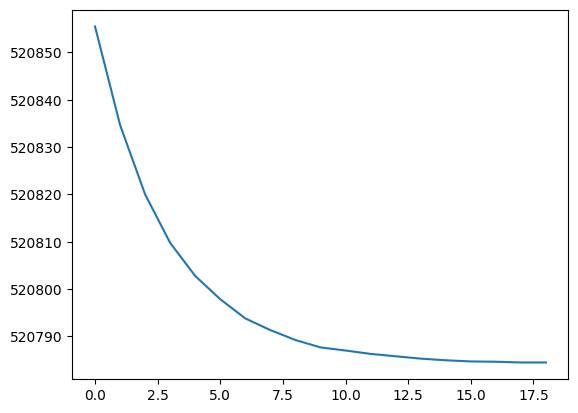

In [122]:
plt.plot(loss['loss'])
plt.show()

In [100]:
G.shape, L.shape

(torch.Size([100, 100]), torch.Size([785, 784]))

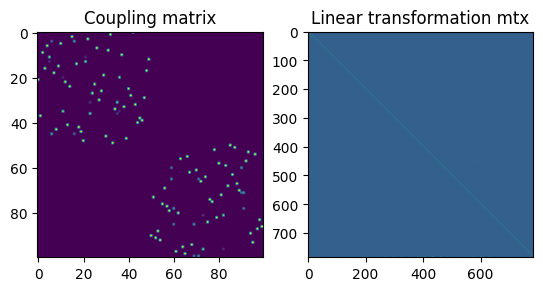

In [123]:
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(G)
axarr[0].set_title('Coupling matrix')
axarr[1].imshow(L)
axarr[1].set_title('Linear transformation mtx')
plt.show()

# Assess the performance with a classifier

Train classifier

In [102]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", C=1.0, class_weight='balanced', random_state=42, verbose=True)
model.fit(X=barycenter, y=yt)

[LibSVM]*
optimization finished, #iter = 74
obj = -73.716730, rho = -0.295107
nSV = 98, nBSV = 82
Total nSV = 98


SVC(class_weight='balanced', random_state=42, verbose=True)

In [103]:
assert model.fit_status_ == 0

Test the fitted SVM on the train set

{'accuracy': 0.799999992,
 'recall': 0.8399999832000004,
 'precision': 0.7777777633744859}

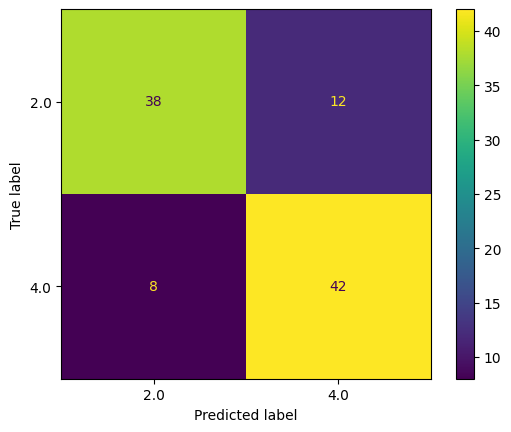

In [139]:
test_svm(model, xt, yt)

Test the SVM on the unmodified source 1

{'accuracy': 0.4599999954000001,
 'recall': 0.4199999916000002,
 'precision': 0.4565217292060494}

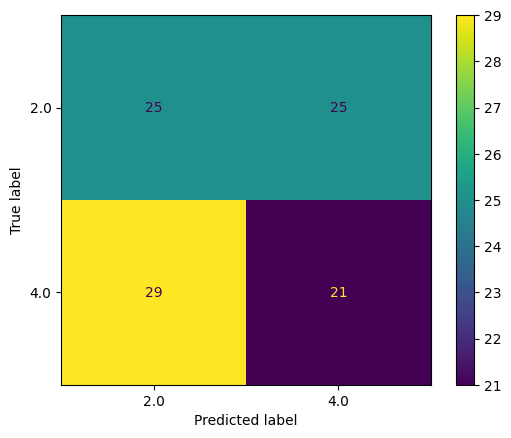

In [137]:
test_svm(model, xs1, ys1, L=None, b=None)

Test the SVM on the modified source 1

{'accuracy': 0.8299999917,
 'recall': 0.8999999820000004,
 'precision': 0.7894736703601111}

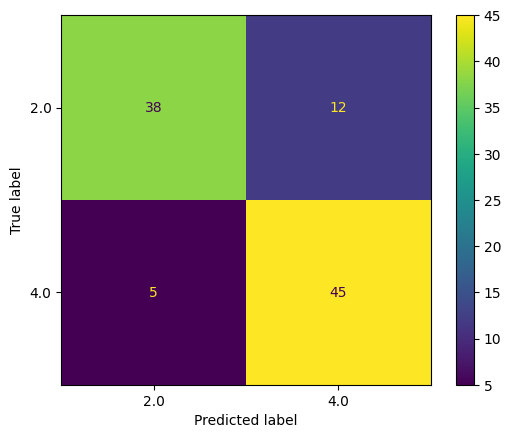

In [135]:
test_svm(model, xs1, ys1, L[0:784], L[784])

Test it on unforseen examples from source 1

In [127]:
new_indices = np.arange(start=n_samples, stop=n_samples * 2, dtype=int)

X_2_new = np.array(ds_2.__getitem__(new_indices)[0])
X_4_new = np.array(ds_4.__getitem__(new_indices)[0])

X_2_new = torch.tensor(X_2_new, dtype=torch.float32, device=device)
X_4_new = torch.tensor(X_4_new, dtype=torch.float32, device=device)

xs1_new = rearrange(torch.stack(
    [X_2_new, X_4_new],
    dim=0),
    'a b c -> (a b) c')

ys1_new = rearrange(torch.stack([torch.ones((n_samples,), device=device) * 2, torch.ones((n_samples,), device=device) * 4]), 'a b -> (a b)')

{'accuracy': 0.4199999958,
 'recall': 0.23999999520000012,
 'precision': 0.3749999882812504}

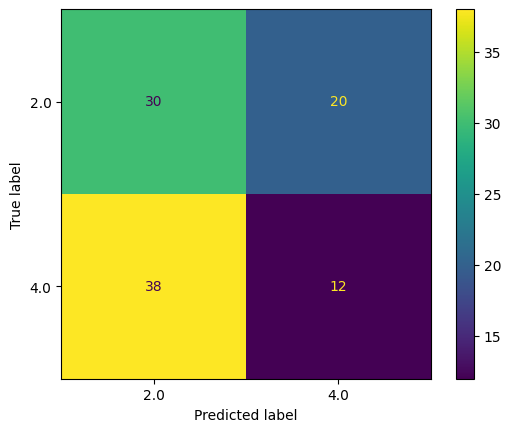

In [133]:
test_svm(model, xs1_new, ys1_new, L=None, b=None)

{'accuracy': 0.6299999937,
 'recall': 0.6399999872000003,
 'precision': 0.6274509680891968}

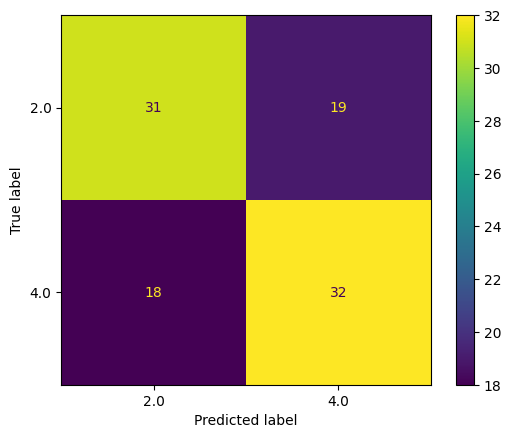

In [131]:
test_svm(model=model, x=xs1_new, y=ys1_new, L=L[0:784], b=L[784])